In [1]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
import os
import datetime

In [3]:
%load_ext tensorboard

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [5]:
files.upload()
!ls

Saving airline-passengers.csv to airline-passengers.csv
airline-passengers.csv	sample_data


In [6]:
#df = pd.read_csv('my_BRENT2019.csv')
df = pd.read_csv('/content/airline-passengers.csv')
df.index = df.Month
df.drop(['Month'],axis=1,inplace = True)
df.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [7]:
df.sort_index(ascending=True, inplace=True)
df.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


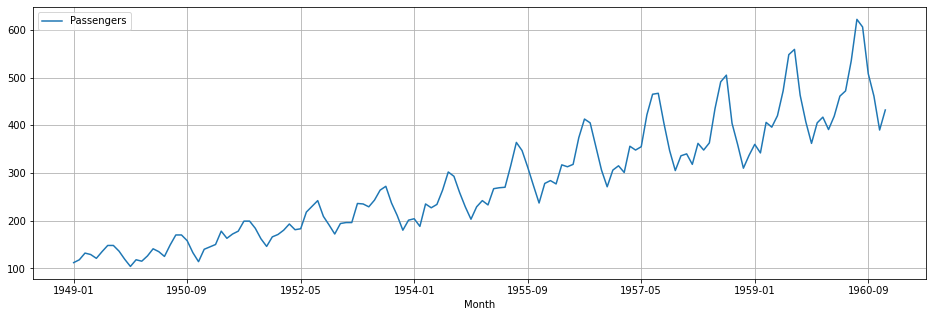

In [8]:
df.plot( figsize = (16,5))

plt.grid('On')
plt.show()

In [9]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


Добавим дату как признаки: как "месяц в году" и (год-1949)

In [10]:
df.index

Index(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
       '1949-07', '1949-08', '1949-09', '1949-10',
       ...
       '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
       '1960-09', '1960-10', '1960-11', '1960-12'],
      dtype='object', name='Month', length=144)

In [11]:
df['month'] = pd.to_datetime(df.index).month
df['year'] = pd.to_datetime(df.index).year - 1949
df.head()

,Passengers,month,year
Month,,,
1949-01,112,1,0
1949-02,118,2,0
1949-03,132,3,0
1949-04,129,4,0
1949-05,121,5,0


In [12]:
for year_n in df['year'].unique():
    print(np.argmax(df.loc[df['year'] == year_n, 'Passengers']))

6
6
6
7
7
6
6
6
7
7
7
6


месяцы с индексами 6 и 7 (что соответствует 7 и 8 месяцу) самые активные по количеству пассажиров

In [13]:
df['is_top_month'] = 0
df.loc[df['month'] == 7, 'is_top_month'] = 1
df.loc[df['month'] == 8, 'is_top_month'] = 1
df.head(12)

,Passengers,month,year,is_top_month
Month,,,,
1949-01,112,1,0,0
1949-02,118,2,0,0
1949-03,132,3,0,0
1949-04,129,4,0,0
1949-05,121,5,0,0
1949-06,135,6,0,0
1949-07,148,7,0,1
1949-08,148,8,0,1
1949-09,136,9,0,0


In [14]:
data = df.copy() # берем все что есть

In [15]:
data.head()

,Passengers,month,year,is_top_month
Month,,,,
1949-01,112,1,0,0
1949-02,118,2,0,0
1949-03,132,3,0,0
1949-04,129,4,0,0
1949-05,121,5,0,0


Делаем нормализацию

In [16]:
def normalize(data, data_mean=0, data_std=0):
    if data_std == 0:
      data_mean = data.mean(axis=0)
      data_std = data.std(axis=0)
    return (data - data_mean) / data_std, data_mean,data_std

In [17]:
train_split = 120
_,d_m,d_s =  normalize(data.iloc[:train_split,0].values)
data.iloc[:, 0]= (data.iloc[:, 0].values - d_m) / d_s

In [18]:
data.head()

,Passengers,month,year,is_top_month
Month,,,,
1949-01,-1.416335,1,0,0
1949-02,-1.352874,2,0,0
1949-03,-1.204797,3,0,0
1949-04,-1.236528,4,0,0
1949-05,-1.321143,5,0,0


Создаем данные для обучения

In [19]:
# список признаков, по которым будем учить
channelIndexes = [0,1,2,3]

# длина теста
valLen = 24
# длина истории для работы
xLen = 3
# отступ тестов от тренировок
bias = 9

# делим
train_data = data.iloc[0 : train_split ,channelIndexes]
val_data = data.iloc[train_split+bias:,channelIndexes]

In [20]:
train_data.head(3)

,Passengers,month,year,is_top_month
Month,,,,
1949-01,-1.416335,1,0,0
1949-02,-1.352874,2,0,0
1949-03,-1.204797,3,0,0


Формируем параметры для генерации выборки

In [21]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
batch_size =24
epochs = 10

Выделяем части на обучение и проверку

In [22]:
Chanel_numb = len(channelIndexes)

start = xLen + future
end = start + train_split-1

xTrain_df = train_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future 

label_start = len(train_data)+bias+xLen + future +1

xVal_df = val_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = val_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

In [23]:
print(xTrain.shape)

print(yTrain.shape)


print(xVal.shape)

print(yVal.shape)

(117, 4)
(117,)
(12, 4)
(12,)


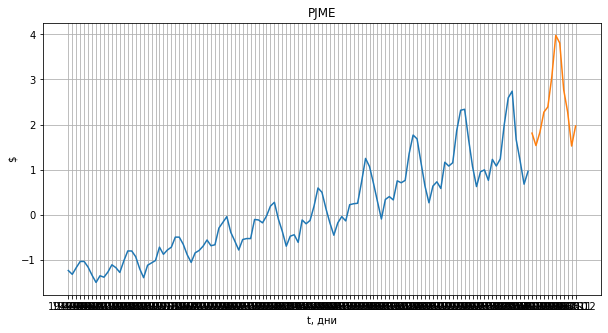

In [24]:
plt.figure(figsize=(10,5))
plt.plot(data.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data.index[yTrain.shape[0]+bias+future+2*xLen-1:],yVal[:])
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('$')
#plt.title('стоимость BRENT в 2010-2018')
plt.title('PJME')
plt.show()

Используем механизм формирования пакетов для обучения

In [25]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)

In [26]:
for batch in dataset_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (10, 3, 4)
Target shape: (10,)


In [27]:
inputs[1,0,:]

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([ 1.22788986, 11.        , 10.        ,  0.        ])>

In [28]:
inputs[1,:,0]

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([1.22788986, 1.68269653, 1.80961932])>

In [29]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=1.809619319330048>

In [30]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (24, 3, 4)
Target shape: (24,)


In [31]:
inputs[0,:,0]

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([-1.06729727, -1.01441278, -0.7182596 ])>

In [32]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=-0.8769130879165481>

In [33]:
logdir = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard( logdir, histogram_freq=1)

сеть: LSTM слои+Conv1D +Dense слой.

Epoch 1/10
5/5 [==============================] - 17s 768ms/step - loss: 1.2575 - mae: 0.9219 - val_loss: 8.0914 - val_mae: 2.7441
Epoch 2/10
5/5 [==============================] - 1s 128ms/step - loss: 0.7989 - mae: 0.7111 - val_loss: 6.1975 - val_mae: 2.3796
Epoch 3/10
5/5 [==============================] - 1s 125ms/step - loss: 0.5698 - mae: 0.6127 - val_loss: 4.3824 - val_mae: 1.9692
Epoch 4/10
5/5 [==============================] - 1s 117ms/step - loss: 0.4068 - mae: 0.5253 - val_loss: 2.6975 - val_mae: 1.4949
Epoch 5/10
5/5 [==============================] - 1s 126ms/step - loss: 0.3137 - mae: 0.4601 - val_loss: 1.4931 - val_mae: 1.0389
Epoch 6/10
5/5 [==============================] - 1s 127ms/step - loss: 0.2759 - mae: 0.3927 - val_loss: 1.0419 - val_mae: 0.8131
Epoch 7/10
5/5 [==============================] - 1s 119ms/step - loss: 0.2603 - mae: 0.3980 - val_loss: 1.1728 - val_mae: 0.8851
Epoch 8/10
5/5 [==============================] - 0s 112ms/step - loss: 0.2142 - mae: 0.3

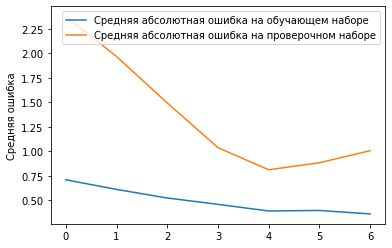

In [34]:
callbaсk = EarlyStopping(monitor='val_mae', patience=2)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(64, return_sequences="True")) # <None, 3,32>
model.add(Conv1D(64, 3, activation="linear")) #(None,3,64)
#model.add(Conv1D(64, 1, activation="linear"))
model.add(Flatten())                          # (None, 3*64)
model.add(Dense(3, activation="linear"))      # (None,3)

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [35]:
hist_val = history.history['val_mae']
hist_train = history.history['mae']

Epoch 1/10
5/5 [==============================] - 0s 59ms/step - loss: 0.1751 - mae: 0.3052 - val_loss: 1.5261 - val_mae: 1.0363
Epoch 2/10
5/5 [==============================] - 0s 59ms/step - loss: 0.1595 - mae: 0.2911 - val_loss: 1.3946 - val_mae: 0.9699
Epoch 3/10
5/5 [==============================] - 0s 60ms/step - loss: 0.1362 - mae: 0.2714 - val_loss: 1.1498 - val_mae: 0.8426
Epoch 4/10
5/5 [==============================] - 0s 65ms/step - loss: 0.1213 - mae: 0.2705 - val_loss: 0.9391 - val_mae: 0.7151
Epoch 5/10
5/5 [==============================] - 0s 63ms/step - loss: 0.1141 - mae: 0.2691 - val_loss: 0.8619 - val_mae: 0.6718
Epoch 6/10
5/5 [==============================] - 0s 65ms/step - loss: 0.1021 - mae: 0.2487 - val_loss: 0.8611 - val_mae: 0.6744
Epoch 7/10
5/5 [==============================] - 0s 65ms/step - loss: 0.0923 - mae: 0.2323 - val_loss: 0.7922 - val_mae: 0.6388
Epoch 8/10
5/5 [==============================] - 0s 66ms/step - loss: 0.0844 - mae: 0.2262 - val

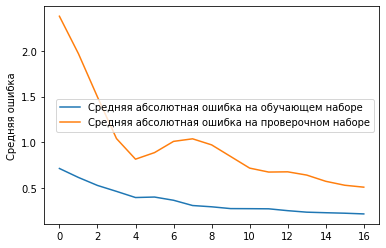

In [36]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])

hist_val.extend(history.history['val_mae'][:])
hist_train.extend(history.history['mae'][:])

plt.plot(hist_train[1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(hist_val[1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [37]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

Валидация:

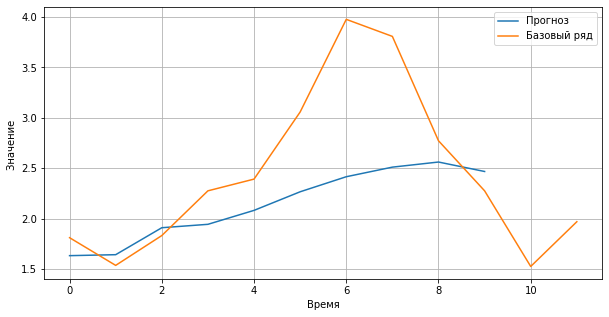

In [38]:
start = 0
step = 120
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

Тренировочные даннные:

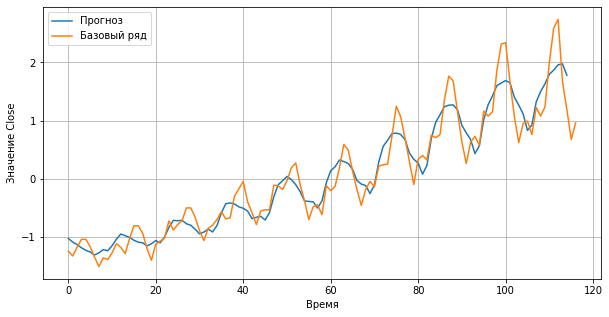

In [39]:
start = 0

plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[start:train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

Проверяем качество модели:

оценим по лаговой корреляции рядов a, b;

если наибольшая корреляция с лагом 0, то отлично;

есди максимум корреляциии на лаге , равном глубине прогноза, то тривиальное предсказание (завтра, как сегодня).

In [40]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

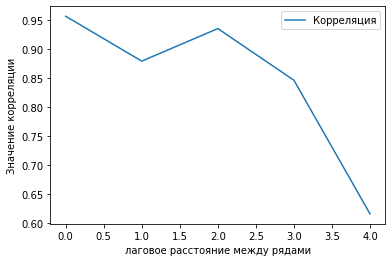

[0.9559280403375846,
 0.8785673387086202,
 0.9346891167846423,
 0.8456246618466956,
 0.6153138878663748]

In [41]:
corr = []
start = 0 # начальная точка для проверки корреляций рядов
step = 9 # число точек для проверки корреляций рядов
h=0
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten() # ряд истиных значений
yPredVal = predVal[start:start+step] # ряд предсказаний 
# смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
for i in range(5):
  corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))
  
plt.plot(corr, 
         label='Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.legend()
plt.show()

corr

Можно добавить обучения на другом размере сети

Epoch 1/100
5/5 [==============================] - 3s 189ms/step - loss: 1.2166 - mae: 0.9264 - val_loss: 7.7939 - val_mae: 2.6944
Epoch 2/100
5/5 [==============================] - 0s 50ms/step - loss: 0.7532 - mae: 0.7030 - val_loss: 5.9617 - val_mae: 2.3377
Epoch 3/100
5/5 [==============================] - 0s 52ms/step - loss: 0.5085 - mae: 0.5797 - val_loss: 4.3070 - val_mae: 1.9593
Epoch 4/100
5/5 [==============================] - 0s 49ms/step - loss: 0.3656 - mae: 0.4910 - val_loss: 3.0465 - val_mae: 1.6136
Epoch 5/100
5/5 [==============================] - 0s 54ms/step - loss: 0.2900 - mae: 0.4333 - val_loss: 2.2024 - val_mae: 1.3357
Epoch 6/100
5/5 [==============================] - 0s 53ms/step - loss: 0.2437 - mae: 0.3889 - val_loss: 1.7076 - val_mae: 1.1456
Epoch 7/100
5/5 [==============================] - 0s 54ms/step - loss: 0.2119 - mae: 0.3529 - val_loss: 1.4547 - val_mae: 1.0382
Epoch 8/100
5/5 [==============================] - 0s 51ms/step - loss: 0.1966 - mae: 0.3

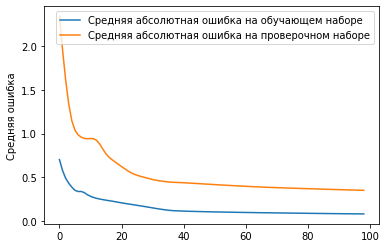

In [42]:
callbaсk = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))

model.add(Flatten())                          # (None, n_Dense*n_lstm)
model.add(Dense(8, activation="linear"))      # (None,n_Dense)

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [43]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

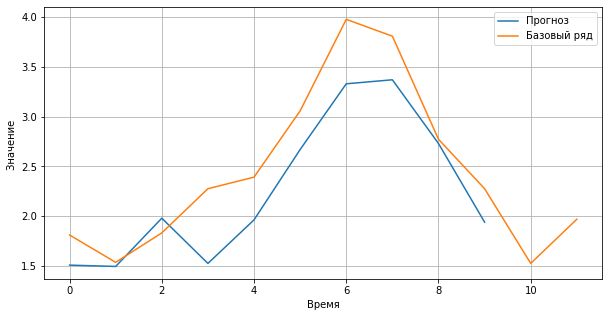

In [44]:
start = 0
step = 144
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

Проверим лаговые корреляции:

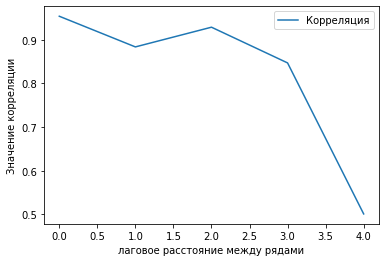

[0.9538488159230599,
 0.883633251637953,
 0.9287641697732638,
 0.8469835774317134,
 0.501214582059102]

In [45]:
corr = []
start = 0 # начальная точка для проверки корреляций рядов
step = 9 # число точек для проверки корреляций рядов
h=0
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten() # ряд истиных значений
yPredVal = predVal[start:start+step] # ряд предсказаний 
# смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
for i in range(5):
  corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))
  
plt.plot(corr, 
         label='Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.legend()
plt.show()

corr

# Финальная модель


In [46]:
inputs.shape

TensorShape([24, 3, 4])

Epoch 1/500
5/5 [==============================] - 3s 201ms/step - loss: 1.1808 - mae: 0.9343 - val_loss: 2.7439 - val_mae: 1.5034
Epoch 2/500
5/5 [==============================] - 0s 50ms/step - loss: 0.4695 - mae: 0.5698 - val_loss: 0.4478 - val_mae: 0.5036
Epoch 3/500
5/5 [==============================] - 0s 54ms/step - loss: 0.2828 - mae: 0.4194 - val_loss: 1.0722 - val_mae: 0.8255
Epoch 4/500
5/5 [==============================] - 0s 57ms/step - loss: 0.2924 - mae: 0.4473 - val_loss: 1.7488 - val_mae: 1.1590
Epoch 5/500
5/5 [==============================] - 0s 57ms/step - loss: 0.1739 - mae: 0.3259 - val_loss: 1.3678 - val_mae: 0.9581
Epoch 6/500
5/5 [==============================] - 0s 54ms/step - loss: 0.1815 - mae: 0.3349 - val_loss: 1.1737 - val_mae: 0.8509
Epoch 7/500
5/5 [==============================] - 0s 56ms/step - loss: 0.1574 - mae: 0.3014 - val_loss: 1.2131 - val_mae: 0.9005
Epoch 8/500
5/5 [==============================] - 0s 58ms/step - loss: 0.1236 - mae: 0.2

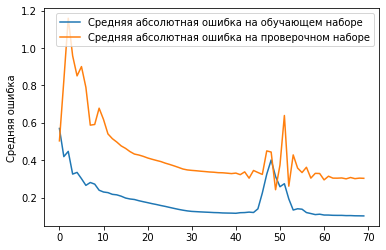

In [47]:
callbaсk = EarlyStopping(monitor='val_mae', patience=20)

model = Sequential()

model.add(LSTM(128, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(Conv1D(64, 3, activation="linear"))
#model.add(Conv1D(64, 1, activation="linear"))


model.add(Flatten())                            
model.add(Dense(8, activation="linear"))

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=500,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

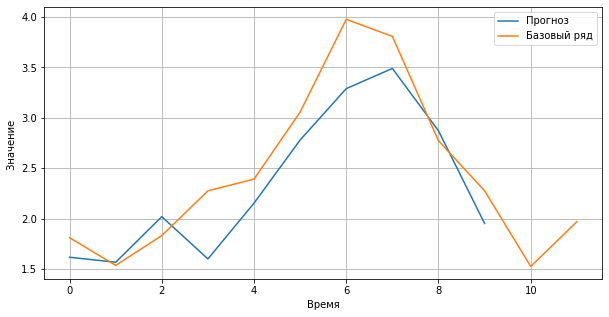

In [48]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

start = 0
step = 144
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

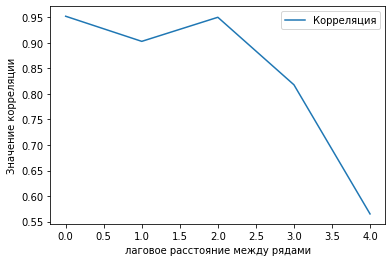

[0.9523317893688131,
 0.9031126480051729,
 0.9502948700823785,
 0.818007223487048,
 0.5649589846816729]

In [49]:
corr = []
start = 0 # начальная точка для проверки корреляций рядов
step = 9 # число точек для проверки корреляций рядов
h=0
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten() # ряд истиных значений
yPredVal = predVal[start:start+step] # ряд предсказаний 
# смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
for i in range(5):
  corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))
  
plt.plot(corr, 
         label='Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.legend()
plt.show()

corr

In [50]:
print(predVal.shape)
print(pred.shape)
pred2 = np.concatenate((pred, predVal), axis=0)
pred2.shape

(10,)
(115,)


(125,)

In [51]:
print(yVal.shape)
print(yTrain.shape)
yTrain2 = np.concatenate((yTrain[:-2], yVal[:-2]), axis=0) # отсекаем по 2 записи из меток, чтобы корректно сопоставить временные ряды
yTrain2.shape

(12,)
(117,)


(125,)

Итоговый результат на всем временном ряду (трейн + тест)

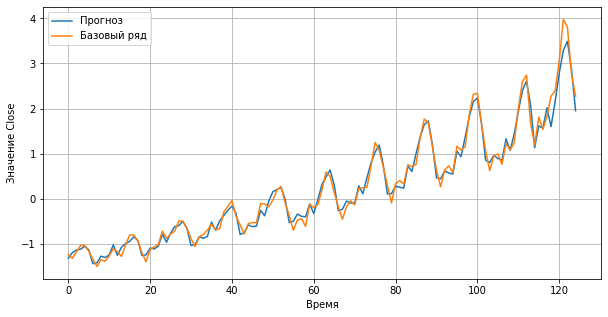

In [52]:
start = 0

plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred2, 
         label='Прогноз')
plt.plot(yTrain2.flatten(), 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

Выводы:
Что сработало: увеличение количества ядер на LSTM слое; добавление Conv1D после LSTM; увеличение порога ранней остановки до 20; увеличение количества эпох обучения. Также удалось улучшить точность, добавив дополнительный признак для двух самых активных месяцев в году, которые видны по данным (тем самым явно указав модели на сезонность).

Не сработало: дополнительные слои LSTM, Conv1D и Dense не давали прироста в качестве.